## Fashion Mnist

### Import all the Dependencies

In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

#### Set constant

In [2]:
BATCH_SIZE = 32
IMAGE_SIZE = 28
CHANNELS=3
EPOCHS=50

#### Import fashion data into tensorflow dataset object

In [3]:
train_df = tf.keras.preprocessing.image_dataset_from_directory(
    "data/train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 48000 files belonging to 10 classes.


In [4]:
class_names = train_df.class_names
class_names

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [5]:
for image_batch, labels_batch in train_df.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 28, 28, 3)
[0 4 7 1 5 7 9 9 2 3 7 4 9 6 8 5 5 6 5 7 4 9 8 0 3 0 8 1 0 3 7 1]


In [6]:
test_df = tf.keras.preprocessing.image_dataset_from_directory(
    "data/test",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 10000 files belonging to 10 classes.


In [7]:
valid_df = tf.keras.preprocessing.image_dataset_from_directory(
    "data/valid",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 12000 files belonging to 10 classes.


Each element in the dataset is a tuple. First element is a batch of 32 elements of images. Second element is a batch of 32 elements of class labels

### Visualize some of the images from our dataset

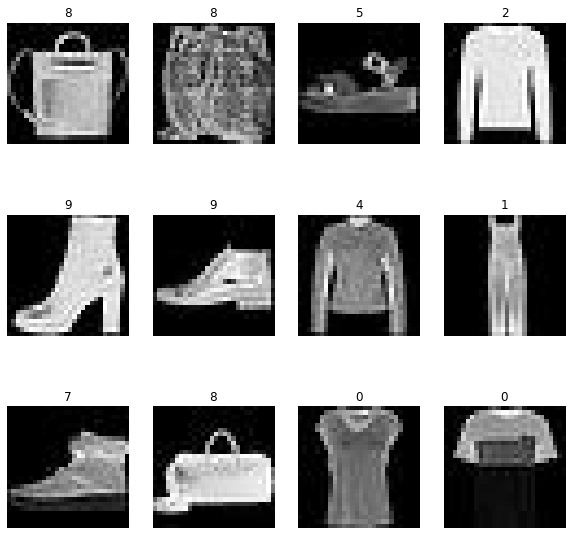

In [8]:
plt.figure(figsize=(10, 10))
for image_batch, labels_batch in train_df.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [9]:
len(train_df)

1500

In [10]:
len(valid_df)

375

In [11]:
len(test_df)

313

### Cache, Shuffle, and Prefetch the Dataset

In [12]:
train_df = train_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
valid_df = valid_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_df = test_df.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

### Building the Model

#### Creating a Layer for Resizing and Normalization

First we should be resizing it to the desired size to improve model performance, we should normalize the image pixel value. This should happen while training as well as inference. Hence we can add that as a layer in our Sequential Model.

In [13]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./27),
])

#### Data Augmentation


Data Augmentation is needed when we have less data, this boosts the accuracy of our model by augmenting the data.
It rorate the image in posssible way and that are used for model training.

In [14]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

#### Applying Data Augmentation to Train Dataset

In [15]:
train_df = train_df.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

### Model Architecture

We use a CNN coupled with a Softmax activation in the output layer. We also add the initial layers for resizing, normalization and Data Augmentation.

We are going to use convolutional neural network (CNN) here. CNN is popular for image classification tasks. Watch below video to understand fundamentals of CNN

In [16]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 10

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(28,28,1)),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.2),
    layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    layers.MaxPooling2D(pool_size=2),
    layers.Dropout(0.3),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [17]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 28, 28, 3)           0         
                                                                 
 conv2d (Conv2D)             (32, 28, 28, 64)          832       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 14, 14, 64)         0         
 )                                                               
                                                                 
 dropout (Dropout)           (32, 14, 14, 64)          0         
                                                                 
 conv2d_1 (Conv2D)           (32, 14, 14, 32)          8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 7, 7, 32)           0         
 2D)                                                  

#### Compiling the Model

We use adam Optimizer, SparseCategoricalCrossentropy for losses, accuracy as a metric

In [18]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [19]:
history = model.fit(
    train_df,
    batch_size=BATCH_SIZE,
    validation_data=valid_df,
    verbose=1,
    epochs=50,
)

Epoch 1/50
1500/1500 [==============================] - 119s 42ms/step - loss: 1.1829 - accuracy: 0.5703 - val_loss: 0.6654 - val_accuracy: 0.7580
Epoch 2/50
1500/1500 [==============================] - 10s 6ms/step - loss: 0.8605 - accuracy: 0.6833 - val_loss: 0.6382 - val_accuracy: 0.7593
Epoch 3/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.7913 - accuracy: 0.7078 - val_loss: 0.5915 - val_accuracy: 0.7785
Epoch 4/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.7588 - accuracy: 0.7215 - val_loss: 0.6033 - val_accuracy: 0.7796
Epoch 5/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.7238 - accuracy: 0.7344 - val_loss: 0.5393 - val_accuracy: 0.8023
Epoch 6/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.7062 - accuracy: 0.7402 - val_loss: 0.5208 - val_accuracy: 0.8057
Epoch 7/50
1500/1500 [==============================] - 10s 7ms/step - loss: 0.6893 - accuracy: 0.7440 - val_loss: 0.5153 - val_

In [20]:
scores = model.evaluate(test_df)

313/313 [==============================] - 21s 4ms/step - loss: 0.4264 - accuracy: 0.8435


You can see above that we get 83.77% accuracy for our test dataset. This is considered to be a pretty good accuracy

In [21]:
scores

[0.42635664343833923, 0.843500018119812]

Scores is just a list containing loss and accuracy value

### Plotting the Accuracy and Loss Curves

In [22]:
history

In [23]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 1500}

In [24]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

loss, accuracy, val loss etc are a python list containing values of loss, accuracy etc at the end of each epoch

In [25]:
type(history.history['loss'])

list

In [26]:
len(history.history['loss'])

50

In [27]:
history.history['loss'][:5] # show loss for first 5 epochs

[1.1829237937927246,
 0.860476016998291,
 0.7913183569908142,
 0.7587751746177673,
 0.7238317728042603]

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

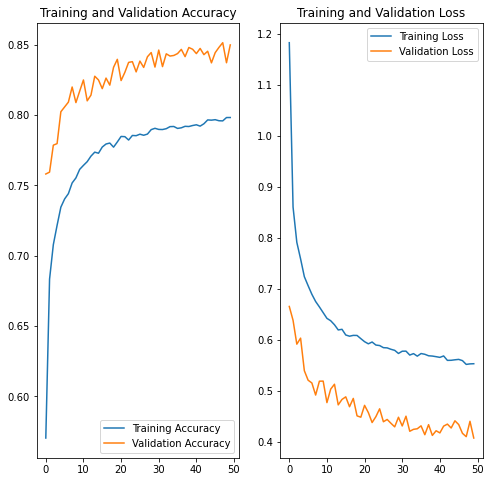

In [30]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Run prediction on a sample image

first image to predict
actual label: 0
predicted label: 0


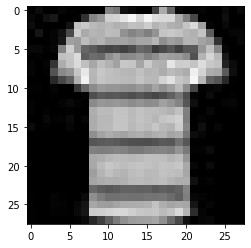

In [31]:
import numpy as np
for images_batch, labels_batch in test_df.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

#### Write a function for inference

In [32]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

Now run inference on few sample imagesNow run inference on few sample images

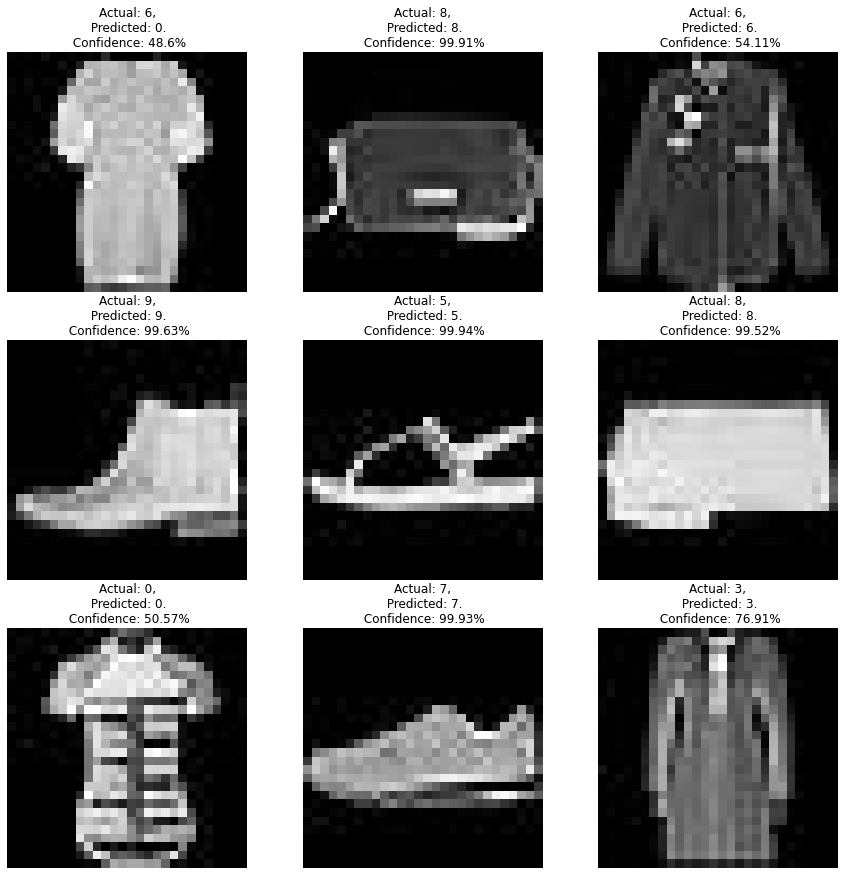

In [33]:
plt.figure(figsize=(15, 15))
for images, labels in test_df.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

#### Saving the Model

In [34]:
model.save("model.h5")